## Customer Segementation
by: Jeremiah Chinyelugo

In today's highly competitive market, it is essential for businesses to understand their customers and tailor their marketing efforts accordingly.

In this project, we will be utilizing an unsupervised machine learning technique to analyze customer data and segment customers based on their purchase behavior and loyalty rating. By doing so, we can understand our customers better, and develop targeted marketing strategies that drive growth and revenue.

#### Importing the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer, InterclusterDistance
import tqdm

warnings.filterwarnings('ignore')

##### loading the data

In [2]:
df = pd.read_csv('C:\\Users\\jerem\\Downloads\\train.csv\\black-friday.csv')
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Loyalty_Rating
0,1000002,P00285442,M,67,16,C,4+,0,8,NaN,NaN,7969,54
1,1000003,P00193542,M,28,15,A,3,0,1,2.0,NaN,15188,48
2,1000004,P00184942,M,46,7,B,2,1,1,8.0,17.0,19836,55
3,1000004,P00346142,M,47,7,B,2,1,1,15.0,NaN,15854,63
4,1000004,P0097242,M,46,7,B,2,1,1,16.0,NaN,15686,47


###### dropping UserID and ProductID

we have some columns that give us no additional information than what we need, so we will be dropping them

In [3]:
df.drop(columns=['User_ID', 'Product_ID'], inplace=True)

In [4]:
# do we have null values, and if yes, how many?

df.isna().sum()

Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Stay_In_Current_City_Years       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2            1601
Product_Category_3            3447
Purchase                         0
Loyalty_Rating                   0
dtype: int64

All our features except Product_Category_2 & Product_Category_3 have no null values.

So how are wo going to deal with the null values?
Well, since those features represent different types of category each customer purchased an item from, it makes sense that those null values represent cases where no product was bought from any of the cartegories, therefore, rather than deleting those instances, we will be replacing the null values with 0 (no item bought from that category)

In [5]:
df.fillna(0, inplace=True)

In [6]:
# Creating Age bin

bins = [18, 21, 39, 59, 93]
labels = ['Young', 'Young-Adult', 'Middle-Aged', 'Old-Adult']

df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
df.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Loyalty_Rating,Age Group
0,M,67,16,C,4+,0,8,0.0,0.0,7969,54,Old-Adult
1,M,28,15,A,3,0,1,2.0,0.0,15188,48,Young-Adult
2,M,46,7,B,2,1,1,8.0,17.0,19836,55,Middle-Aged
3,M,47,7,B,2,1,1,15.0,0.0,15854,63,Middle-Aged
4,M,46,7,B,2,1,1,16.0,0.0,15686,47,Middle-Aged


### colors

In this notebook, we will be using primarily two colors to represent Gender and Marital status
* Gender = Red -> Men, Black -> Women
* Marital status = Red -> Single, Black -> Married

In [7]:
gray = '#868686'
dark = '#000000'
dark_background = '#0e1c26'
red = '#e15759'
white = '#e7e7e7'

## Exploratory Data Analysis (E.D.A)

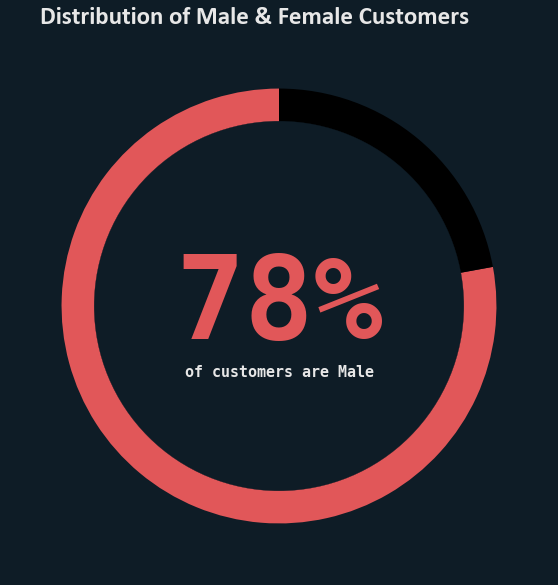

In [8]:
vals = df['Gender'].value_counts().values
labels = ['Male','Female']

colors = ['#e15759','#000000']

circle = plt.Circle((0,0), 0.85, color='#0e1c26')

fig, ax = plt.subplots(figsize=(25,10))

background_color = '#0e1c26'
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)

ax.pie(vals, colors=colors, startangle=90)
ax.add_artist(circle)
ax.annotate('78%', xy=(0, 0), color='#e15759', weight='bold', fontsize=115, fontfamily='monospace',
            ha='center', va='center')
ax.annotate('of customers are Male', xy=(0, -0.3), color=white, weight='bold', fontsize=15, fontfamily='monospace',
            ha='center', va='center')
plt.text(x=-1.1, y=1.3, s='Distribution of Male & Female Customers', color=white, weight='bold', fontfamily='calibri',
        fontsize=25)

plt.show()

##### Distribution of Age

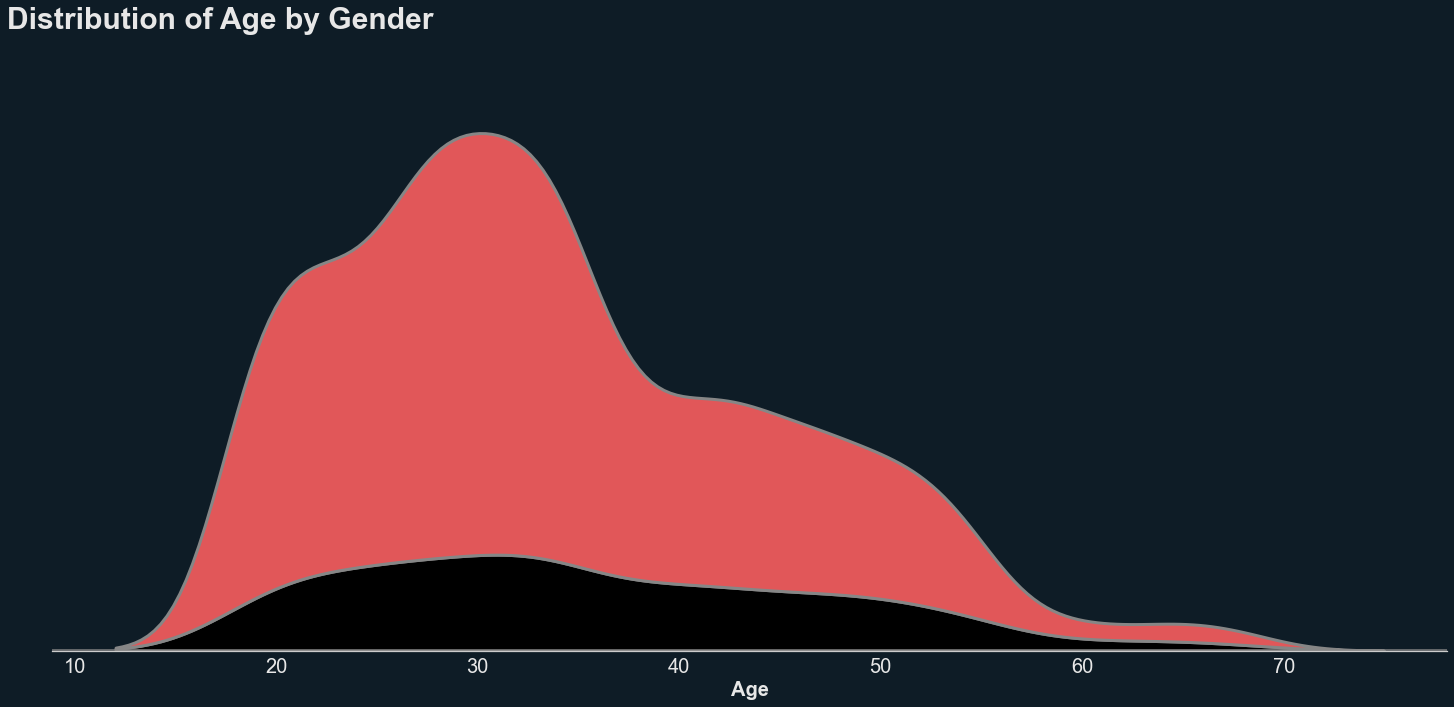

In [9]:
fig, ax = plt.subplots(figsize=(25,10))

background_color = dark_background
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)

sns.kdeplot(x=df['Age'], fill=True, multiple='stack', alpha=1, hue=df['Gender'],
           palette=[red,dark], edgecolor=gray, lw=3, legend=False)
ax.tick_params(axis='both', colors=white, labelsize=20,)
ax.set_xlabel('Age', fontsize=20, color=white, weight='bold')
ax.set_yticks([])
ax.set_ylabel("")

ax.grid()
ax.axhline(y=0, color=gray, lw=5, alpha=.7)

for s in ['top','right','left']:
    ax.spines[s].set_visible(False)
    
fig.text(0.1,1, 'Distribution of Age by Gender', color=white, fontsize=30, weight='bold',
        ha='left', va='center')

plt.show()

As confirmed above, majority of the customers are male and a healthy chunk of our entire customer base are beteween the ages of 21 - 39, i.e 'Yound-Adult'

#### Distribution by Age Group

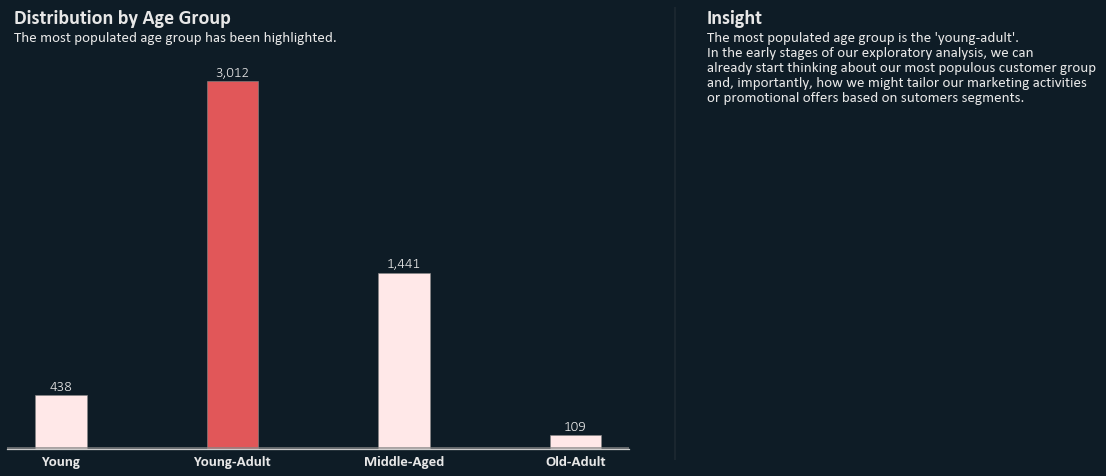

In [10]:
ab_order = ['Young', 'Young-Adult', 'Middle-Aged', 'Old-Adult']

data = df['Age Group'].value_counts()[ab_order]

color_map = ['#FFE8E8' for _ in range(4)]
color_map[1] = red

fig, ax = plt.subplots(1,1, figsize=(9, 6))

background_color = dark_background
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)

ax.bar(data.index, data, width=0.3, edgecolor=gray,
      lw=0.6, color=color_map)

# Annotations
for i in data.index:
    ax.annotate(f"{int(data[i]):,}", xy=(i, data[i]+70), ha='center', va='center', fontsize=15,
                                 weight='light', fontfamily='calibri', color=white)
    
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
ax.set_xticklabels(data.index, fontfamily='calibri', rotation=0, color=white, weight='bold', fontsize=15)

# Title and sub-title

fig.text(0.03, 1.06, "Distribution by Age Group", fontsize=20, weight='bold',
        fontfamily='calibri', color=white)
fig.text(0.03, 1.02, 'The most populated age group has been highlighted.',
        fontfamily='calibri', fontsize=15, color=white)
fig.text(1.1, 1.06, 'Insight', fontsize=20, fontweight='bold', color=white,
         fontfamily='calibri')

fig.text(1.1, 0.88, """
The most populated age group is the 'young-adult'.
In the early stages of our exploratory analysis, we can 
already start thinking about our most populous customer group 
and, importantly, how we might tailor our marketing activities
or promotional offers based on sutomers segments.""",
        fontsize=15, fontfamily='calibri', color=white)

ax.axhline(y=0, color=gray, lw=5, alpha=.7)
ax.grid()

import matplotlib.lines as lines
l1 = lines.Line2D([1.05, 1.05], [0.05, 1.1], transform=fig.transFigure, figure=fig, color=gray, lw=0.2)
fig.lines.extend([l1])

ax.set_yticks([])
ax.set_ylabel("")

plt.tight_layout()
plt.show()

#### Stay in Current city

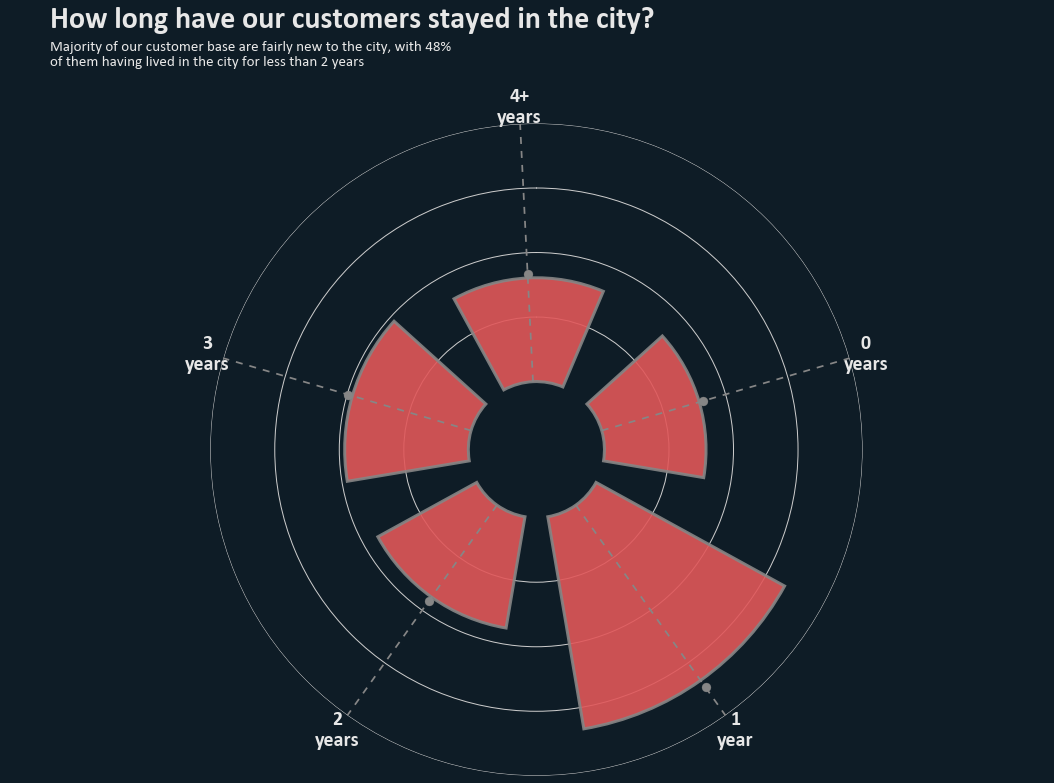

In [11]:
values = df['Stay_In_Current_City_Years'].value_counts().sort_index(ascending=False).values
labels = ['4+\nyears', '3\nyears', '2\nyears', '1\nyear', '0\nyears']

#print(labels, values)

ANGLES = np.linspace(0.05, 2*np.pi - 0.05, len(labels), endpoint=False)
length = (max(values)*1.2//4)


# VISUALIZATION

fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection':'polar'})
background_color = dark_background
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)

ax.set_theta_offset(1*np.pi/2)
ax.set_ylim(-min(values)*0.67, min(values)*0.67)

ax.bar(ANGLES, values, width=0.9, zorder=10, alpha=0.9, lw=3, ec=gray, color=red)

# 40 constrains the length
ax.vlines(ANGLES, 0, length*4, ls=(0, (4,4)), zorder=11, color=gray)

ax.scatter(x=ANGLES, y=[1.04*num for num in values], s=80, zorder=11, color=gray)

ax.set_xticks(ANGLES)
ax.set_xticklabels(labels, size=20, fontfamily='calibri', weight='bold', color=white)

ax.set_yticklabels([])
ax.set_yticks([length*i for i in range(1,5)]) # handles the gridlines

ax.spines['start'].set_color('none')
ax.spines['polar'].set_color('none')

ax.xaxis.grid(False)

for tick in ax.xaxis.get_major_ticks():
    tick.set_pad(10) # handles distance of labels from xaxis, i.e black, asian etc

fig.text(-0.05, 1, s=f"How long have our customers stayed in the city?",
                ha='left', va='center', fontfamily='calibri', fontsize=30, weight='bold', color=white)
fig.text(-0.05, 0.96, s=f"""
Majority of our customer base are fairly new to the city, with 48%
of them having lived in the city for less than 2 years 
""",
                ha='left', va='center', fontfamily='calibri', fontsize=15, color=white)
fig.text(-0.1,0.5, ' ')
fig.text(1.1,0.5, ' ')
fig.text(-0.05,1, ' ')

plt.show()

##### Product category

In [12]:
# converting all product category values to integer

for prod in ['Product_Category_1', 'Product_Category_2', 'Product_Category_3']:
    df[prod] = df[prod].astype(int)

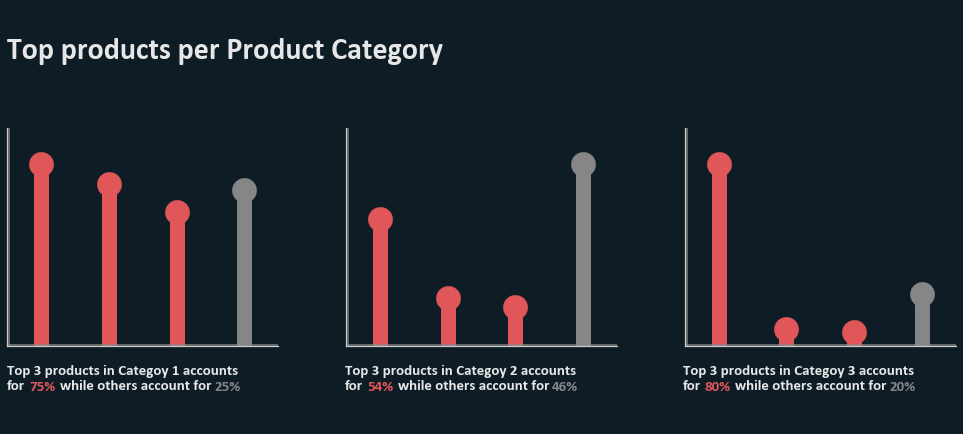

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(17, 4))
fig.patch.set_facecolor(background_color) # figure background color
ax[0].set_facecolor(background_color)
ax[1].set_facecolor(background_color)
ax[2].set_facecolor(background_color)

fig.subplots_adjust(wspace=0.25)



data1 = df['Product_Category_1'].value_counts().sort_values(ascending=False)[:3]
others = df['Product_Category_1'].value_counts().sort_values(ascending=False)[3:].values.sum()
data1 = data1.append(pd.Series({'others':others}))

data2 = df['Product_Category_2'].value_counts().sort_values(ascending=False)[:3]
others = df['Product_Category_2'].value_counts().sort_values(ascending=False)[3:].values.sum()
data2 = data2.append(pd.Series({'others':others}))

data3 = df['Product_Category_3'].value_counts().sort_values(ascending=False)[:3]
others = df['Product_Category_3'].value_counts().sort_values(ascending=False)[3:].values.sum()
data3 = data3.append(pd.Series({'others':others}))

df_list = [data1, data2, data3]
cols = ['Category 1', 'Category 2', 'Category 3']
plot_dict = {}

for i, key in enumerate(ax.ravel()):
    plot_dict[key] = cols[i]

for i, (axes, col) in enumerate(plot_dict.items()):
    axes.vlines(df_list[i].index.astype(str)[:3], ymin=0, ymax=df_list[i].values[:3], lw=15, color=red,)
    axes.scatter(x=df_list[i].index.astype(str)[:3], y=df_list[i].values[:3], color=red, s=600)
    
    axes.vlines(df_list[i].index.astype(str)[3:], ymin=0, ymax=df_list[i].values[3:], lw=15, color=gray)
    axes.scatter(x=df_list[i].index.astype(str)[3:], y=df_list[i].values[3:], color=gray, s=600)
    
    axes.set_ylim([0, df_list[i].values.max()*1.2])
    axes.set_xlim([-0.5,3.5])
    
    for s in ['top','right']:
        axes.spines[s].set_visible(False)
    
    axes.set_yticks([])
    axes.set_xticks([])
    axes.set_xticklabels(axes.get_xticks())
    
    axes.axhline(y=0, color=gray, lw=5, alpha=.7)
    axes.axvline(x=-0.5, color=gray, lw=5, alpha=.7)
    
    
# texts
fig.text(0.5, -0.15," ")
fig.text(0.125, 0.11, f'''
Top 3 products in Categoy 1 accounts 
for
''', color=white, ha='left', va='top', fontfamily='calibri',weight='bold', fontsize=15)
fig.text(0.143, 0.0557, f'''
75%
''', color=red, ha='left', va='top', fontfamily='calibri',weight='bold', fontsize=15)
fig.text(0.168, 0.057, f'''
while others account for 
''', color=white, ha='left', va='top', fontfamily='calibri',weight='bold', fontsize=15)
fig.text(0.294, 0.054, f'''
25%
''', color=gray, ha='left', va='top', fontfamily='calibri',weight='bold', fontsize=15)

# =======================================================================================
fig.text(0.401, 0.11, f'''
Top 3 products in Categoy 2 accounts 
for
''', color=white, ha='left', va='top', fontfamily='calibri',weight='bold', fontsize=15)
fig.text(0.419, 0.0557, f'''
54%
''', color=red, ha='left', va='top', fontfamily='calibri',weight='bold', fontsize=15)
fig.text(0.444, 0.057, f'''
while others account for 
''', color=white, ha='left', va='top', fontfamily='calibri',weight='bold', fontsize=15)
fig.text(0.570, 0.054, f'''
46%
''', color=gray, ha='left', va='top', fontfamily='calibri',weight='bold', fontsize=15)

# =======================================================================================
fig.text(0.677, 0.11, f'''
Top 3 products in Categoy 3 accounts 
for
''', color=white, ha='left', va='top', fontfamily='calibri',weight='bold', fontsize=15)
fig.text(0.695, 0.0557, f'''
80%
''', color=red, ha='left', va='top', fontfamily='calibri',weight='bold', fontsize=15)
fig.text(0.720, 0.057, f'''
while others account for 
''', color=white, ha='left', va='top', fontfamily='calibri',weight='bold', fontsize=15)
fig.text(0.846, 0.054, f'''
20%
''', color=gray, ha='left', va='top', fontfamily='calibri',weight='bold', fontsize=15)

# =======================================================================================
fig.text(0.125, 1.3, f"""
Top products per Product Category
""", color=white, ha='left', va='top', fontfamily='calibri',weight='bold', fontsize=30)

plt.show()

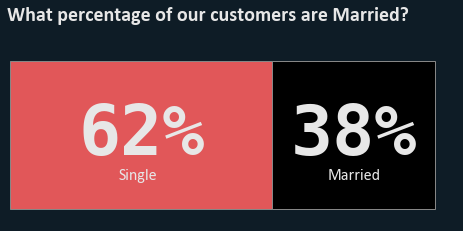

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,3))
fig.patch.set_facecolor(background_color) 
ax.set_facecolor(background_color)

data = df['Marital_Status'].value_counts(normalize=True)

ax.barh(0, data.values[0], color=red, ec=gray, lw=1)
ax.barh(0, data.values[1], color=dark, left=data.values[0], ec=gray, lw=1)

for s in ['top','right', 'bottom', 'left']:
        ax.spines[s].set_visible(False)
        
ax.set_yticks([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_xticklabels([])

ax.annotate(f"{data.values[0]:.0%}", xy=(.31, 0), color=white, fontfamily='monospace', fontsize=70, weight='bold',
           ha='center', va='center')
ax.annotate(f"Single", xy=(.3, -0.22), color=white, fontfamily='calibri', fontsize=16,
           ha='center', va='center')

ax.annotate(f"{data.values[1]:.0%}", xy=(.8084, 0), color=white, fontfamily='monospace', fontsize=70, weight='bold',
           ha='center', va='center')
ax.annotate(f"Married", xy=(.8084, -0.22), color=white, fontfamily='calibri', fontsize=16,
           ha='center', va='center')

fig.text(0.12, 1.03, "What percentage of our customers are Married?", fontfamily='calibri', weight='bold',
        fontsize=20, color=white)
fig.text(0.12,0.1, ' ')

plt.show()

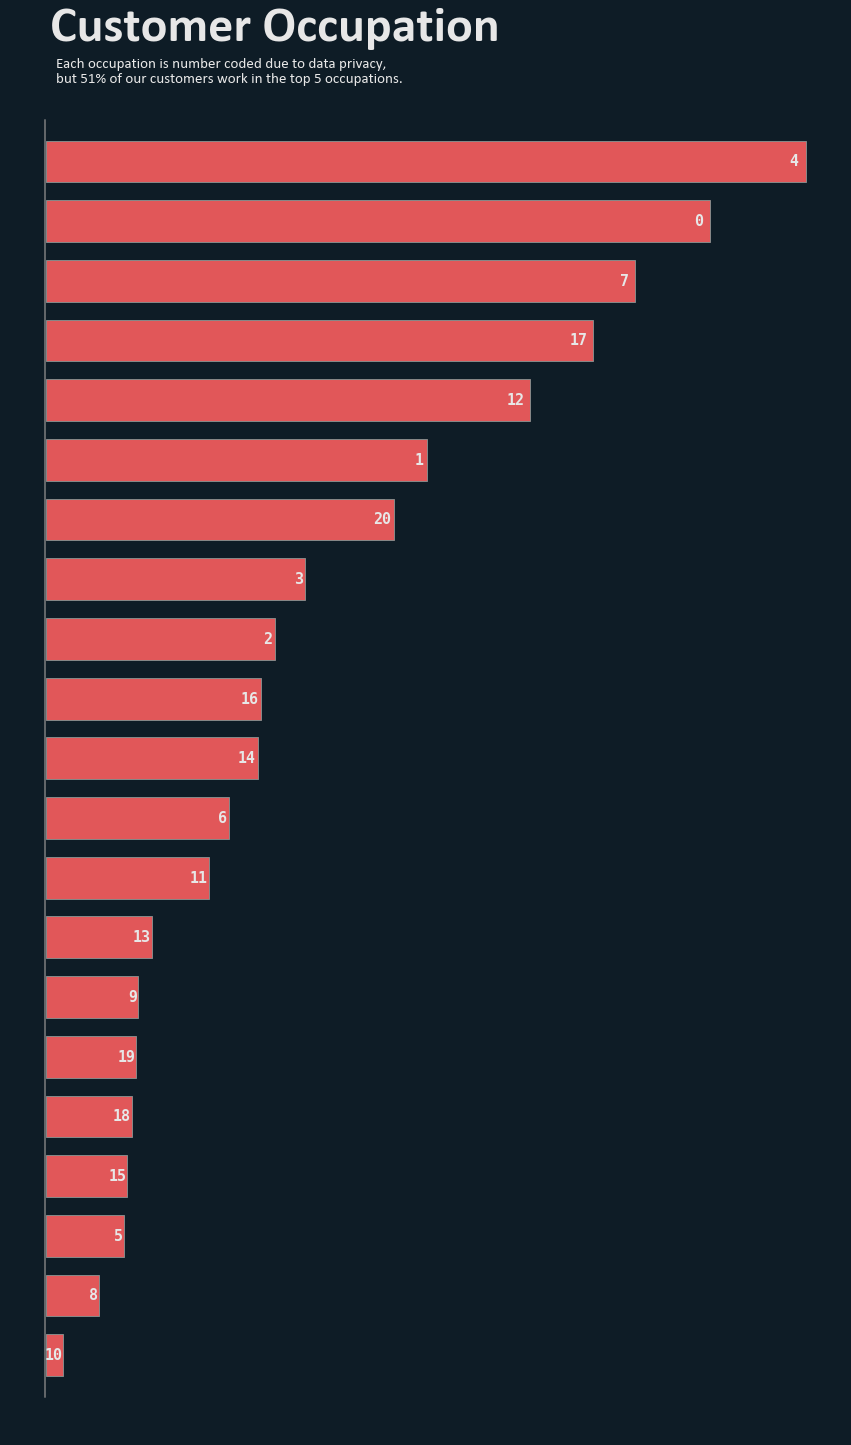

In [15]:
# Plotting population by ethnic groups

data = df['Occupation'].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(1,1, figsize=(15,25))
fig.patch.set_facecolor(background_color) 
ax.set_facecolor(background_color)

ax.barh(y=data.index.astype(str), width=data.values, height=0.7, ec=gray, color=red, lw=1)
ax.invert_yaxis()

for i in range(len(data)):
    ax.annotate(f"{data.index[i]}", xy=(data.values[i]*.99, data.index[i].astype(str)), weight='bold',
               ha='right', va='center', color=white, fontsize=15, fontfamily='monospace')

for s in ['top','bottom','right','left']:
    ax.spines[s].set_visible(False)


ax.set_xticks([])
ax.set_yticks([])
ax.axvline(x=-0.5, ymin=0.03, ymax=.97, color=gray, lw=2, alpha=.7)
fig.text(0.154, 0.92, ' Customer Occupation', color=white, weight='bold', fontfamily='calibri',
        fontsize=50, ha='left', va='top')

fig.text(0.17, 0.90, f"""
Each occupation is number coded due to data privacy,
but 51% of our customers work in the top 5 occupations.
""", color=white, fontsize=15, fontfamily='calibri', ha='left', va='top')

plt.show()

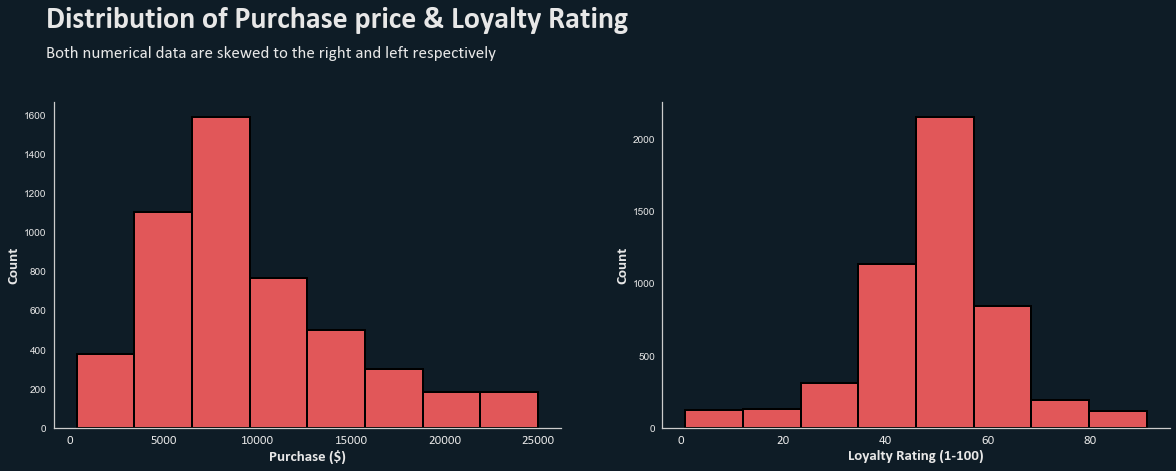

In [16]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,6))
fig.patch.set_facecolor(background_color) 
ax[0].set_facecolor(background_color)
ax[1].set_facecolor(background_color)

sns.histplot(df['Purchase'], ax=ax[0], bins=8, color=red, alpha=1, lw=2)
sns.histplot(df['Loyalty_Rating'], ax=ax[1], bins=8, color=red, alpha=1, lw=2)

for s in ['top','right']:
    ax[0].spines[s].set_visible(False)
for s in ['top','right']:
    ax[1].spines[s].set_visible(False)

ax[0].set_xlabel('Purchase ($)', color=white, fontfamily='calibri', fontsize=15, weight='bold')
ax[0].set_xticklabels([int(x) for x in ax[0].get_xticks()], color=white, fontfamily='calibri', fontsize=13)
ax[0].set_ylabel('Count', color=white, fontfamily='calibri', fontsize=15, weight='bold')
ax[0].set_yticklabels([int(x) for x in ax[0].get_yticks()], color=white)

ax[1].set_xlabel('Loyalty Rating (1-100)', color=white, fontfamily='calibri', fontsize=15, weight='bold')
ax[1].set_xticklabels([int(x) for x in ax[1].get_xticks()], color=white, fontfamily='calibri', fontsize=13)
ax[1].set_ylabel('Count', color=white, fontfamily='calibri', fontsize=15, weight='bold')
ax[1].set_yticklabels([int(x) for x in ax[1].get_yticks()], color=white)

fig.text(0.12, 1.1, "Distribution of Purchase price & Loyalty Rating", color=white, weight='bold',
        fontfamily='calibri', fontsize=30, ha='left', va='top')
fig.text(0.12, 1.05, """
Both numerical data are skewed to the right and left respectively
""", color=white, fontfamily='calibri', fontsize=17, ha='left', va='top')
ax[0].grid()
ax[1].grid()

plt.show()

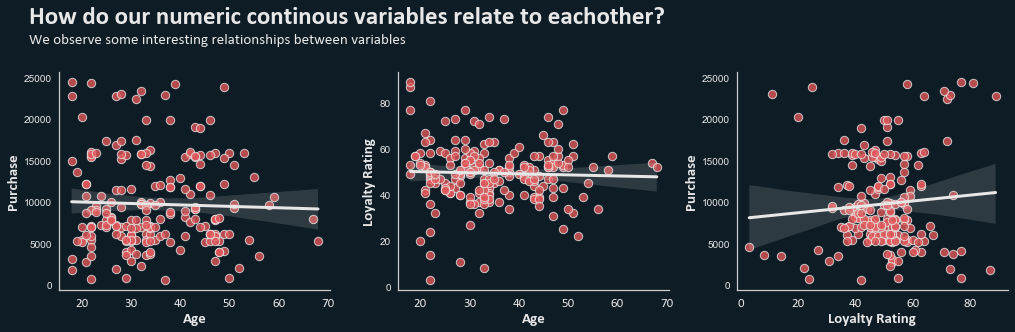

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(17, 4))
fig.patch.set_facecolor(background_color) 
ax[0].set_facecolor(background_color)
ax[1].set_facecolor(background_color)
ax[2].set_facecolor(background_color)

sns.regplot(data=df[:200], x='Age', y='Purchase', ax=ax[0], color=red,
           scatter_kws={'edgecolor':white, 's':70, 'lw':1},
           line_kws={'color':white,'lw':3})
sns.regplot(data=df[:200], x='Age', y='Loyalty_Rating', ax=ax[1], color=red,
           scatter_kws={'edgecolor':white, 's':70, 'lw':1},
           line_kws={'color':white,'lw':3})
sns.regplot(data=df[:200], y='Purchase', x='Loyalty_Rating', ax=ax[2], color=red,
           scatter_kws={'edgecolor':white, 's':70, 'lw':1},
           line_kws={'color':white,'lw':3})

fig.text(0.1, 1.05, 'How do our numeric continous variables relate to eachother?', fontsize=25, fontfamily='calibri', color=white,
        weight='bold')
fig.text(0.1, 0.98, 'We observe some interesting relationships between variables', color=white,
        fontfamily='calibri', fontsize=15)

# ===========================================================================
ax[0].set_xlabel('Age', color=white, fontfamily='calibri', fontsize=15, weight='bold')
ax[0].set_xticklabels([int(x) for x in ax[0].get_xticks()], color=white, fontfamily='calibri', fontsize=13)
ax[0].set_ylabel('Purchase', color=white, fontfamily='calibri', fontsize=15, weight='bold')
ax[0].set_yticklabels([int(x) for x in ax[0].get_yticks()], color=white)
ax[0].grid()

ax[1].set_xlabel('Age', color=white, fontfamily='calibri', fontsize=15, weight='bold')
ax[1].set_xticklabels([int(x) for x in ax[1].get_xticks()], color=white, fontfamily='calibri', fontsize=13)
ax[1].set_ylabel('Loyalty Rating', color=white, fontfamily='calibri', fontsize=15, weight='bold')
ax[1].set_yticklabels([int(x) for x in ax[1].get_yticks()], color=white)
ax[1].grid()

ax[2].set_xlabel('Loyalty Rating', color=white, fontfamily='calibri', fontsize=15, weight='bold')
ax[2].set_xticklabels([int(x) for x in ax[2].get_xticks()], color=white, fontfamily='calibri', fontsize=13)
ax[2].set_ylabel('Purchase', color=white, fontfamily='calibri', fontsize=15, weight='bold')
ax[2].set_yticklabels([int(x) for x in ax[2].get_yticks()], color=white)
ax[2].grid()

plt.subplots_adjust(wspace=.25)

sns.despine()

## Clustering

Now we have a good understanding of our data, i'll be clusterting our data using the **K-Means** algorithm.

We will use both the **Elbow Method** and the **Silhouette score** to select the appropraite number of clusters for our data.

In [18]:
# Selecting clustering data

cluster_data = df[['Purchase', 'Loyalty_Rating']]
cluster_data

,Purchase,Loyalty_Rating
0,7969,54
1,15188,48
2,19836,55
3,15854,63
4,15686,47
...,...,...
4995,1382,86
4996,19039,56
4997,15703,78
4998,774,57


In [19]:
# scaling and transforming the data

scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

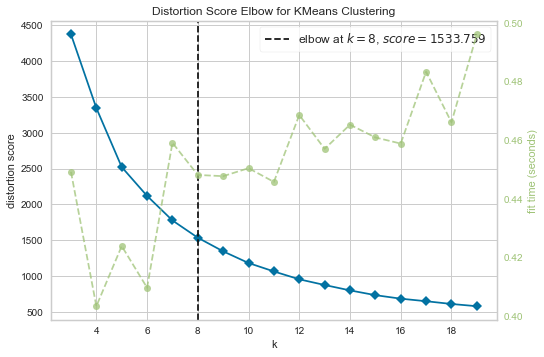

In [20]:
# visulizing the inertia scores for clusters 3 - 20

kmeans = KMeans()

visualizer = KElbowVisualizer(kmeans, k=(3,20))
visualizer.fit(cluster_data_scaled)
visualizer.show()
plt.show()

In [21]:
# finding the best cluster insensitive to change in random seed

n_clusters = range(5, 14)
rand_state = range(70,91)
silhouette_scores = {}

for k in tqdm.tqdm(n_clusters):
    score_list = []
    for s in rand_state:
        kmean = KMeans(n_clusters=k, n_init=10, random_state=s)
        labels = kmean.fit_predict(cluster_data_scaled)
        score = silhouette_score(cluster_data_scaled, labels)
        score_list.append(score)
    silhouette_scores[k] = score_list

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:25<00:00, 16.22s/it]


In [22]:
# creating the heatmap dataframe

silhouette_scores_df = pd.DataFrame(silhouette_scores)
silhouette_scores_df.set_index(pd.Index(list(rand_state)), inplace=True)

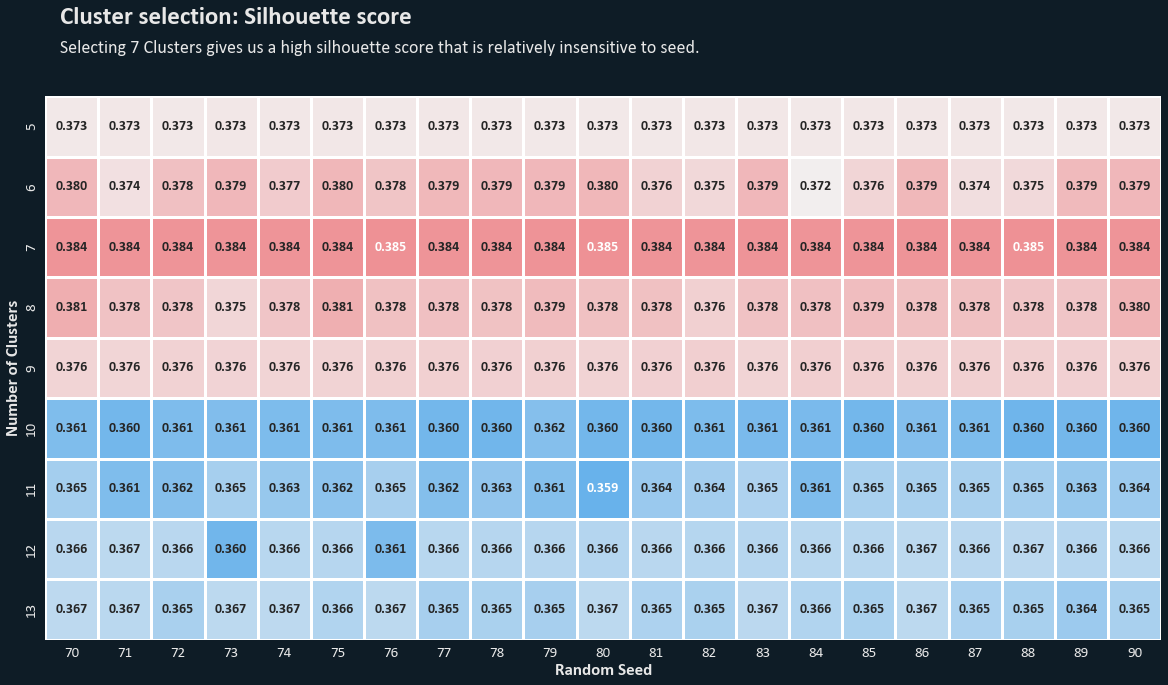

In [23]:
# visualizing the dataframe

fig, ax = plt.subplots(1,1, figsize=(20,10))
fig.patch.set_facecolor(background_color) 

cmap = sns.diverging_palette(240, 10, l=70, as_cmap=True)
sns.heatmap(silhouette_scores_df.T, annot=True, lw=2.5, cbar=False, fmt='.3f', cmap=cmap,
           annot_kws=dict(fontsize=14, weight='bold', fontfamily='calibri'))

fig.text(0.135, 0.98, 'Cluster selection: Silhouette score', fontsize=25, fontweight='bold', fontfamily='calibri', color=white)
fig.text(0.135, 0.94, 'Selecting 7 Clusters gives us a high silhouette score that is relatively insensitive to seed.', 
         fontfamily='calibri', fontsize=18, color=white)


ax.set_xticklabels(list(rand_state), color=white, fontfamily='calibri', fontsize=15)
ax.set_yticklabels(list(n_clusters), color=white, fontfamily='calibri', fontsize=15)
plt.xlabel('Random Seed', fontfamily='calibri', fontsize=17, weight='bold', color=white)
plt.ylabel('Number of Clusters', fontfamily='calibri', fontsize=17, weight='bold', color=white)
plt.show()

from the heatmap above, for 7 clusters, random seeds: 76, 80, and 88 had the highest silhouette scores, so we will go with random seed (76)

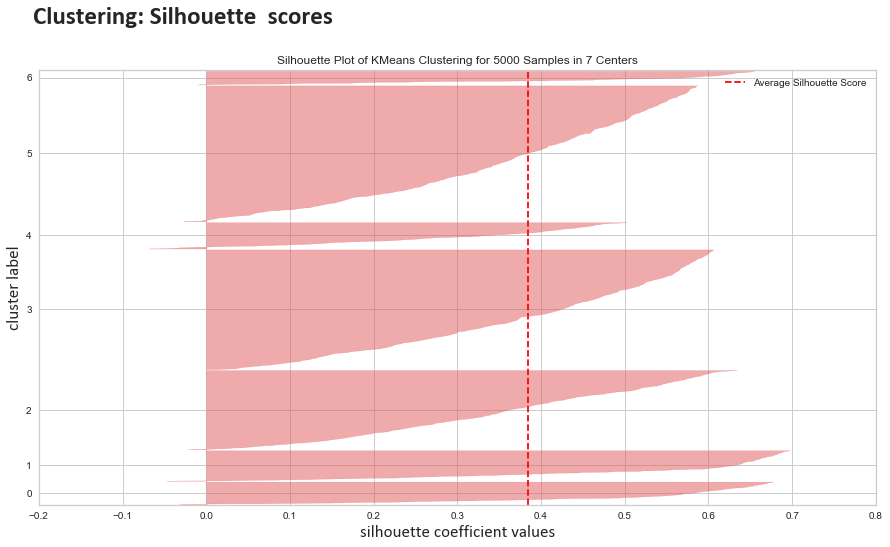

In [24]:
model = KMeans(7, n_init=10, random_state=76)

fig = plt.figure(figsize=(15,8))

visualizer = SilhouetteVisualizer(model, colors=[red]*7)
visualizer.fit(cluster_data_scaled)

fig.text(0.12,.96, "Clustering: Silhouette  scores", fontweight='bold', 
        fontfamily='calibri', fontsize=25)
plt.xlabel('Silhouette Coefficient Values', fontfamily='calibri', fontsize=17,)
plt.ylabel('Cluster Label', fontfamily='calibri', fontsize=17,)

visualizer.show()
plt.show()

Next we will be displaying our clusters using an **InterCluster Distance Map** which displays each cluster in 2 dimensions with the distance to other clusters preserved.

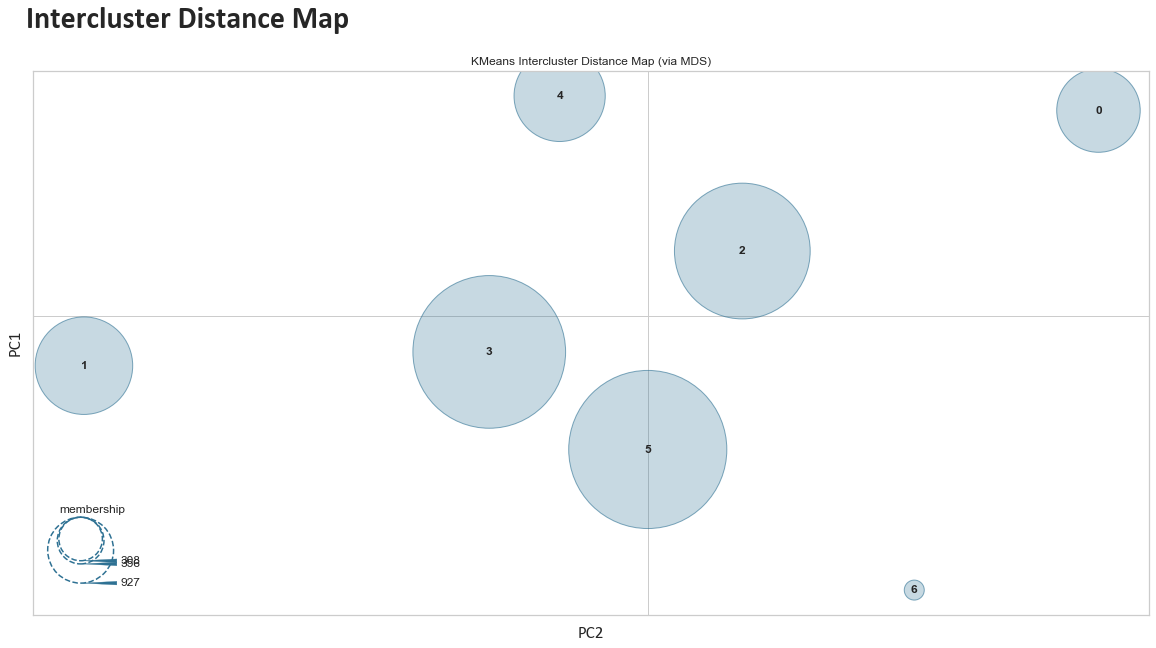

In [25]:
model = KMeans(n_clusters=7, n_init=10, random_state=76)

fig = plt.figure(figsize=(20,10))

visualizer = InterclusterDistance(model,)
visualizer.fit(cluster_data_scaled)

fig.text(0.12,.94, "Intercluster Distance Map", fontweight='bold', 
        fontfamily='calibri', fontsize=30)
plt.xlabel('PC2', fontfamily='calibri', fontsize=17,) # principal component from PCA
plt.ylabel('PC1', fontfamily='calibri', fontsize=17,)

visualizer.show()
plt.show()

In [26]:
# cretaing labels for our clusters

df['cluster'] = model.labels_

we have 7 clusters,and there are some patterns we can notice straight away based on Loyalty rating and Purchase. 

Therefore, we will be creating labels for our clusters based on these observations

* 0 - high purchase, high loyalty = most valuable
* 1 - low purchase, low loyalty = Least Valuable
* 2 - high purchase, average loyalty = very valuable
* 3 - average purchase, subpar loyalty = valuable
* 4 - high purchase, low loyalty = Target
* 5 - subpar purchase, average loyalty = less valuable
* 6 - low purchase, high loyalty = valuable

**Target**<br/>
To maximize our marketing budget, the target cluster should be focused on by tailoring marketing efforts to their needs and preferences, because increasing their loyalty can drive up sales revenue.

**Most valuable**
for this cluster, we should offer perks and rewards such as early access to items and exclusive discounts to incentivize them to continue purchasing.

**Less and Least valuable**
considering that these customers are charactirized by low purchases and loyalty ratings, we shouldn't focus our marketing startegy towards these clusters as the cost of converting them into valuable customers will be too expensive and it willbe more beneficial to focus on other clusters.

In [27]:
# mapping the cluster labels

cluster_labels = {
    0: 'most valuable',
    1: 'least valuable',
    2: 'very valuable',
    3: 'valuable',
    4: 'target',
    5: 'less valuable',
    6: 'valuable'
}

df['Cluster_Label'] = df['cluster'].map(cluster_labels)

### Analyzing our clusters

In [28]:
angles = np.linspace(0, 2*np.pi, 6, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

values = df['Cluster_Label'].value_counts().values
values = np.concatenate((values, [values[0]]))

labels = df['Cluster_Label'].value_counts().index

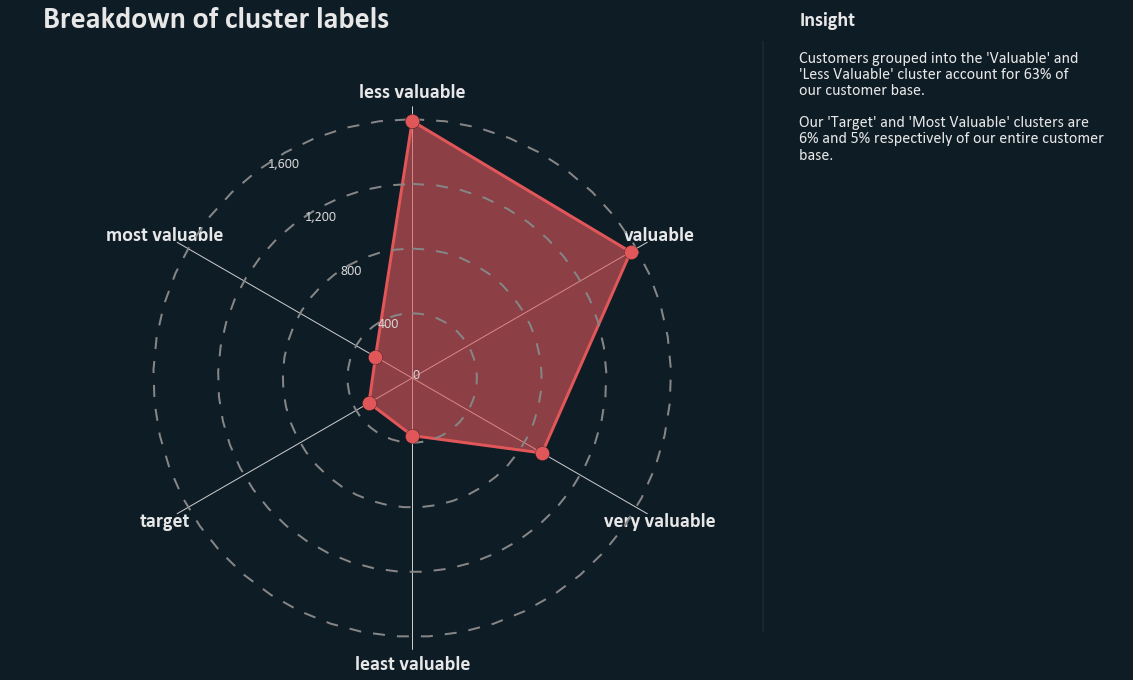

In [29]:
h_angles = np.linspace(0,2*np.pi)
H0 = np.zeros(len(h_angles))
H1 = np.ones(len(h_angles))*400
H2 = np.ones(len(h_angles))*800
H3 = np.ones(len(h_angles))*1200
H4 = np.ones(len(h_angles))*1600

from math import pi
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax = plt.subplot(1,1,1, polar=True)
fig.patch.set_facecolor(dark_background)
ax.set_facecolor(dark_background)

ax.plot(angles, values, 'o-', lw=3, color=red)
ax.fill(angles, values, color=red, alpha=0.6)
ax.scatter(angles, values, s=200, zorder=10, color=red, ec='k')

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids((angles*180/np.pi)[:6], labels=labels)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=20, fontfamily='calibri', weight='bold', color=white)

ax.set_yticks([])
ax.yaxis.grid(False)
ax.xaxis.grid(False)

ax.spines['start'].set_color('none')
ax.spines['polar'].set_color('none')

ax.plot(h_angles, H0, ls=(0, (6,6)), c=gray, lw=2)
ax.plot(h_angles, H1, ls=(0, (6,6)), c=gray, lw=2)
ax.plot(h_angles, H2, ls=(0, (6,6)), c=gray, lw=2)
ax.plot(h_angles, H3, ls=(0, (6,6)), c=gray, lw=2)
ax.plot(h_angles, H4, ls=(0, (6,6)), c=gray, lw=2)




PAD = 0.05
ax.text(-0.6, 0 + PAD, "0", size=14, fontfamily="calibri", color='lightgray')
ax.text(-0.6, 380 + PAD, "400", size=14, fontfamily="calibri", color='lightgray')
ax.text(-0.6, 780 + PAD, "800", size=14, fontfamily="calibri", color='lightgray')
ax.text(-0.6, 1180 + PAD, "1,200", size=14, fontfamily="calibri", color='lightgray')
ax.text(-0.6, 1580 + PAD, "1,600", size=14, fontfamily="calibri", color='lightgray')

ax.grid()

fig.text(0, 1, 'Breakdown of cluster labels', ha='left', va='center',
        weight='bold', fontsize=30, color=white, fontfamily='calibri')
l1 = lines.Line2D([1, 1], [0.15, .97], transform=fig.transFigure, figure=fig,color=gray, lw=0.2)
fig.lines.extend([l1])

fig.text(1.05, 1, ha='left', va='center', fontsize=20, weight='bold', s='Insight', color=white, fontfamily='calibri')
fig.text(1.01, 0.88, ha='left', va='center', fontfamily='calibri', color=white, fontsize=16,
        s="""
        Customers grouped into the 'Valuable' and
        'Less Valuable' cluster account for 63% of
        our customer base.
        
        Our 'Target' and 'Most Valuable' clusters are 
        6% and 5% respectively of our entire customer
        base.
        """)

fig.text(-0.05,0.5, ' ')
fig.text(1.5,0.5, ' ')
fig.text(-0.05,1, ' ')

plt.show()

In [30]:
from math import pi
data = df.groupby('Cluster_Label')[['Age Group']].value_counts(normalize=True).unstack().T

 
def make_spider(row, title, color):
    h_angles = np.linspace(0,2*np.pi)
    H0 = np.zeros(len(h_angles))
    H1 = np.ones(len(h_angles))*.1
    H2 = np.ones(len(h_angles))*.3
    H3 = np.ones(len(h_angles))*.5
    H4 = np.ones(len(h_angles))*.7

    angles = np.linspace(0, 2*np.pi, 4, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    
    labels = ['Young', 'Young-Adult', 'Middle-Aged', 'Old-Adult']
    vals = data[title].values
    vals = np.concatenate((vals, [vals[0]]))
    

    # Initialise the spider plot
    ax = plt.subplot(3,3,row+1, polar=True)
    fig.patch.set_facecolor(dark_background)
    ax.set_facecolor(dark_background)

    ax.plot(angles, vals, 'o-', lw=3, color=red)
    ax.fill(angles, vals, color=red, alpha=0.6)
    ax.scatter(angles, vals, s=100, zorder=10, color=red, ec='k')

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids((angles*180/np.pi)[:4], labels=labels)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=15, fontfamily='calibri', weight='bold', color=white)

    ax.set_yticks([])
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)

    ax.spines['start'].set_color('none')
    ax.spines['polar'].set_color('none')
    
    ax.plot(h_angles, H0, ls=(0, (6,6)), c=gray, lw=2)
    ax.plot(h_angles, H1, ls=(0, (6,6)), c=gray, lw=2)
    ax.plot(h_angles, H2, ls=(0, (6,6)), c=gray, lw=2)
    ax.plot(h_angles, H3, ls=(0, (6,6)), c=gray, lw=2)
    ax.plot(h_angles, H4, ls=(0, (6,6)), c=gray, lw=2)



    PAD = 0.05
    ax.text(-0.6, 0 + PAD, "0", size=14, fontfamily="calibri", color='lightgray')
    ax.text(-0.6, .08 + PAD, "10%", size=14, fontfamily="calibri", color='lightgray')
    ax.text(-0.6, .28 + PAD, "30%", size=14, fontfamily="calibri", color='lightgray')
    ax.text(-0.6, .48 + PAD, "50%", size=14, fontfamily="calibri", color='lightgray')
    ax.text(-0.6, .68 + PAD, "70%", size=14, fontfamily="calibri", color='lightgray')

    plt.title(f"Cluster: {title}", size=25, fontfamily='calibri',fontweight='bold', y=1.15, color=white)
    
    ax.grid()
    plt.subplots_adjust(hspace=0.6)


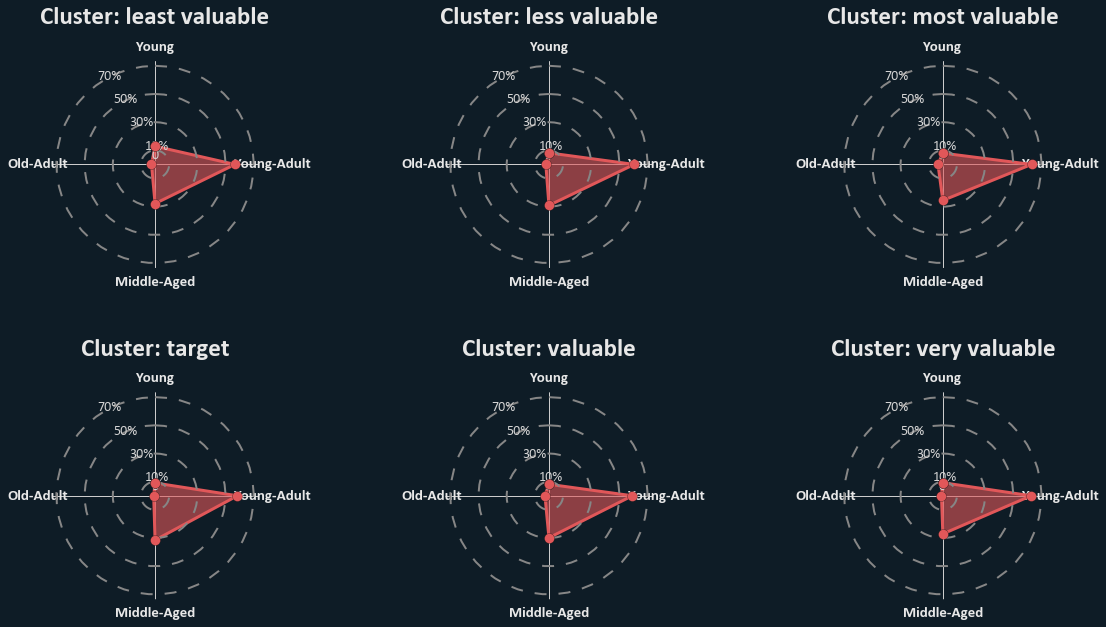

In [31]:
fig = plt.figure(figsize=(20,16))
fig.patch.set_facecolor(dark_background)

for i, title in enumerate(data.columns):
    make_spider(row=i, title=title, color=red)

All cluster have similar distribution of Age groups, with 'Young-Adults' making up 60% of each cluster

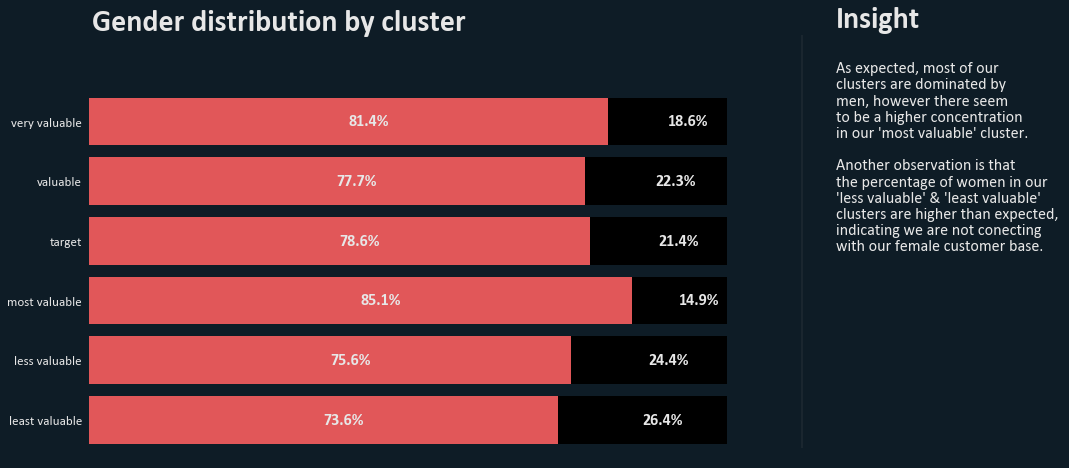

In [32]:
# bar chart
data = df.groupby('Cluster_Label')[['Gender']].value_counts(normalize=True).unstack()

fig, ax = plt.subplots(1,1, figsize=(12,7))
fig.patch.set_facecolor(dark_background)
ax.set_facecolor(dark_background)

ax.barh(data.index, data['M'], color=red)
ax.barh(data.index, data['F'], left=data['M'], color=dark)
for i in data.index:
    ax.annotate(f"{data.loc[i,'M']:.1%}", 
                xy=(data.loc[i,'M']/2,i), color=white,
               fontfamily='calibri', va='center', fontsize=16, weight='bold')
    
    ax.annotate(f"{data.loc[i,'F']:.1%}", 
                xy=(data.loc[i,'F']/2 + data.loc[i,'M'], i), color=white,
               fontfamily='calibri', va='center', fontsize=16, weight='bold')
    
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
plt.grid('off', alpha=0.1)
ax.grid()
ax.set_xticks([])
ax.set_yticklabels(data.index, color=white, fontfamily='calibri', fontsize=13)

fig.text(0.129, 0.98, 'Gender distribution by cluster', fontsize=30, weight='bold', fontfamily='calibri', color=white)  

l1 = lines.Line2D([0.95, .95], [0.15, .97], transform=fig.transFigure, figure=fig,color=gray, lw=0.2)
fig.lines.extend([l1])

fig.text(.99, 1, ha='left', va='center', fontsize=30, weight='bold', s='Insight', color=white, fontfamily='calibri')
fig.text(.99, 0.95, 
         """
As expected, most of our 
clusters are dominated by 
men, however there seem 
to be a higher concentration
in our 'most valuable' cluster.

Another observation is that 
the percentage of women in our
'less valuable' & 'least valuable' 
clusters are higher than expected, 
indicating we are not conecting 
with our female customer base.
""" , fontsize=16,fontfamily='calibri', color=white,
        ha='left', va='top')   

plt.show()

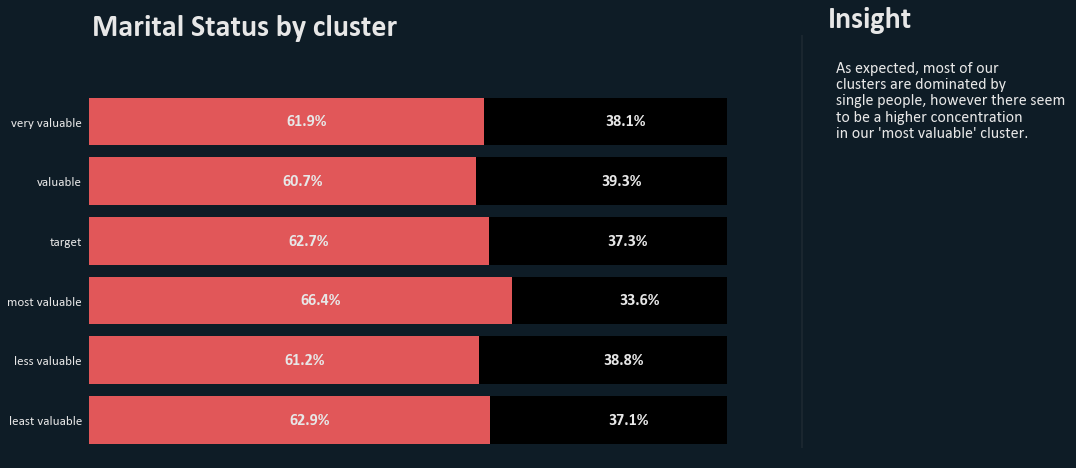

In [33]:
data = df.groupby('Cluster_Label')[['Marital_Status']].value_counts(normalize=True).unstack()

fig, ax = plt.subplots(1,1, figsize=(12,7))
fig.patch.set_facecolor(dark_background)
ax.set_facecolor(dark_background)

ax.barh(data.index, data[0], color=red)
ax.barh(data.index, data[1], left=data[0], color=dark)
for i in data.index:
    ax.annotate(f"{data.loc[i,0]:.1%}", 
                xy=(data.loc[i,0]/2,i), color=white,
               fontfamily='calibri', va='center', fontsize=16, weight='bold')
    
    ax.annotate(f"{data.loc[i,1]:.1%}", 
                xy=(data.loc[i,1]/2 + data.loc[i,0], i), color=white,
               fontfamily='calibri', va='center', fontsize=16, weight='bold')
    
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
plt.grid('off', alpha=0.1)
ax.grid()
ax.set_xticks([])
ax.set_yticklabels(data.index, color=white, fontfamily='calibri', fontsize=13)

fig.text(0.129, 0.97, 'Marital Status by cluster', fontsize=30, weight='bold', fontfamily='calibri', color=white)  

l1 = lines.Line2D([0.95, .95], [0.15, .97], transform=fig.transFigure, figure=fig,color=gray, lw=0.2)
fig.lines.extend([l1])

fig.text(.98, 1, ha='left', va='center', fontsize=30, weight='bold', s='Insight', color=white, fontfamily='calibri')
fig.text(.99, 0.95, 
         """
As expected, most of our 
clusters are dominated by 
single people, however there seem 
to be a higher concentration
in our 'most valuable' cluster.
""" , fontsize=16,fontfamily='calibri', color=white,
        ha='left', va='top')   

plt.show()

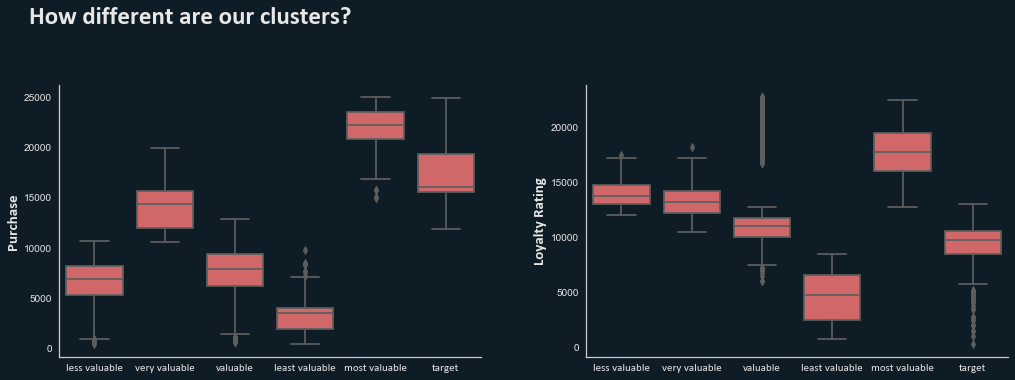

In [34]:
labels = ['less valuable', 'very valuable', 'valuable', 'least valuable', 'most valuable', 'target']

fig, ax = plt.subplots(1, 2, figsize=(17, 5))
fig.patch.set_facecolor(background_color) 
ax[0].set_facecolor(background_color)
ax[1].set_facecolor(background_color)

sns.boxplot(data=df, x='Cluster_Label', y='Purchase', ax=ax[0], color=red)
sns.boxplot(data=df, x='Cluster_Label', y='Loyalty_Rating', ax=ax[1], color=red)


fig.text(0.1, 1.05, 'How different are our clusters?', fontsize=25, fontfamily='calibri', color=white,
        weight='bold')

# ===========================================================================
ax[0].set_xticklabels(labels, color=white, fontfamily='calibri', fontsize=11)
ax[0].set_xlabel('')
ax[0].set_ylabel('Purchase', color=white, fontfamily='calibri', fontsize=15, weight='bold')
ax[0].set_yticklabels([int(x) for x in ax[0].get_yticks()], color=white)
ax[0].grid(False)

ax[1].set_xticklabels(labels, color=white, fontfamily='calibri', fontsize=11)
ax[1].set_xlabel('')
ax[1].set_ylabel('Loyalty Rating', color=white, fontfamily='calibri', fontsize=15, weight='bold')
ax[1].set_yticklabels([int(x) for x in ax[0].get_yticks()], color=white)
ax[1].grid(False)

plt.subplots_adjust(wspace=.25)

sns.despine()

In [35]:
data1 = df.groupby('Cluster_Label')['Product_Category_1'].value_counts().unstack().T
new_row = {'Product_Category_1':0, 'least valuable':0, 'less valuable':0, 'most_valuable':0, 'target':0, 'valuable':0, 'very valuable':0}
data1.loc[0] = new_row
data1.sort_index(inplace=True)
data1.fillna(0, inplace=True)

data2 = df.groupby('Cluster_Label')['Product_Category_2'].value_counts().unstack().T
new_row = {'Product_Category_2':1, 'least valuable':0, 'less valuable':0, 'most_valuable':0, 'target':0, 'valuable':0, 'very valuable':0}
data2.loc[1] = new_row
data2.sort_index(inplace=True)
data2.fillna(0, inplace=True)

data3 = df.groupby('Cluster_Label')['Product_Category_3'].value_counts().unstack().T

new_row = {'Product_Category_3':0, 'least valuable':0, 'less valuable':0, 'most_valuable':0, 'target':0, 'valuable':0, 'very valuable':0}
data3.loc[1] = new_row
data3.loc[2] = new_row
data3.loc[7] = new_row

data3.sort_index(inplace=True)
data3.fillna(0, inplace=True)

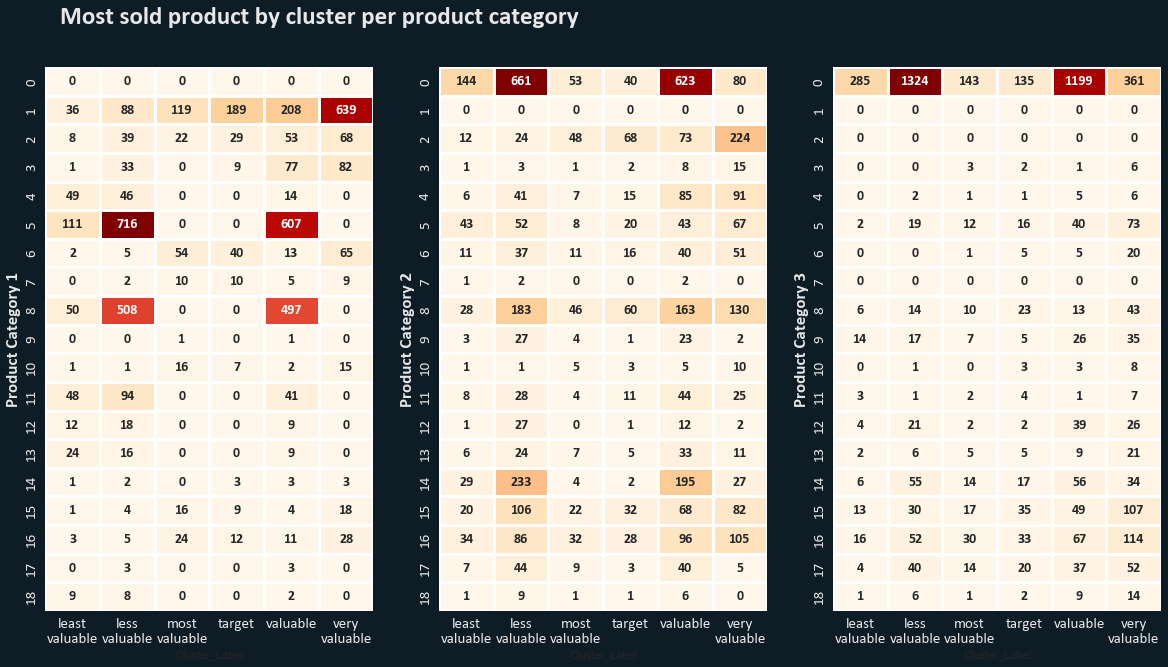

In [36]:
labels = ['least\nvaluable', 'less\nvaluable', 'most\nvaluable', 'target', 'valuable', 'very\nvaluable']

fig, ax = plt.subplots(1,3, figsize=(20,10))
fig.patch.set_facecolor(background_color) 

cmap = 'OrRd'
sns.heatmap(data1, annot=True, lw=2.5, cbar=False, fmt='.0f', cmap=cmap,
           annot_kws=dict(fontsize=14, weight='bold', fontfamily='calibri'), ax=ax[0])
sns.heatmap(data2, annot=True, lw=2.5, cbar=False, fmt='.0f', cmap=cmap,
           annot_kws=dict(fontsize=14, weight='bold', fontfamily='calibri'), ax=ax[1])
sns.heatmap(data3, annot=True, lw=2.5, cbar=False, fmt='.0f', cmap=cmap,
           annot_kws=dict(fontsize=14, weight='bold', fontfamily='calibri'), ax=ax[2])

fig.text(0.135, 0.94, 'Most sold product by cluster per product category', fontsize=25, fontweight='bold', fontfamily='calibri', color=white)

for i in range(3):
    ax[i].set_xticklabels(labels, color=white, fontfamily='calibri', fontsize=15, rotation=0)
    ax[i].set_yticklabels(data1.index, color=white, fontfamily='calibri', fontsize=15)
    ax[i].set_ylabel(f'Product Category {i+1}', fontfamily='calibri', fontsize=17, weight='bold', color=white)
plt.show()

## Conclusion

We have been able to develope a model that has the ability to cluster customers based on their loyalty rating and purchasing behavior. This model can help us identify which customers our marketing efforts should be targeted towards, in order to increase their loyalty rating and drive up sales.

Furthermore, our analysis has revealed the popularity of products in each product category among each cluster, providing valuable insights to the marketing team for crafting tailored marketing ads.

Based on our findings, we recommend that the marketing department conduct a survey targeting the customers we have classified as "Targets" to identify opportunities for improving our services to them. Additionally, our analysis has highlighted a gap in our engagement with female customers, who constitute a small proportion of the "Most Valuable" cluster. We recommend that the marketing team develop strategies to address this gap.